In [224]:
##Combine available source home csvs into one csv
import os
import glob
import pandas as pd
extension='csv'

os.chdir(r"C:\Users\b-byr\Desktop\Training Dataset\Home\CSVs")

if os.path.exists("allhome.csv"):
    os.remove("allhome.csv")

all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "allhome.csv", index=False, encoding='utf-8-sig')

os.chdir(r"C:\Users\b-byr\Desktop\Training Dataset\NotHome\CSVs")

if os.path.exists("allnothome.csv"):
    os.remove("allnothome.csv")

all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#Combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "allnothome.csv", index=False, encoding='utf-8-sig')


In [229]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import utils 
import matplotlib

##CSV Created from PCAP to CSV Utility in /PCAP Manipulation/

#Add labels categorizing whether the data is home or not
homedata = pd.read_csv(r'C:\Users\b-byr\Desktop\Training Dataset\Home\CSVs\allhome.csv', low_memory=False)
homedata["Label"]="home"

targethomedata= pd.read_csv(r'C:\Users\b-byr\Desktop\Training Dataset\TargetHome\CSVs\targethome.csv', low_memory=False)
targethomedata["Label"]="home"

nothomedata = pd.read_csv(r'C:\Users\b-byr\Desktop\Training Dataset\NotHome\CSVs\allnothome.csv', low_memory=False)
nothomedata["Label"]="nothome"

#Limit to TCP Flows, reduce number of nothome after filtering for TCP -> To be adjusted
homedata = homedata[homedata['Protocol'] == 6]
nothomedata = nothomedata[nothomedata['Protocol'] == 6]
targethomedata = targethomedata[targethomedata['Protocol'] == 6]
nothomedata=nothomedata.head(n=500)

#Check that the dataframes are populated successfully
print(homedata.shape)
print(nothomedata.shape)
print(targethomedata.shape)

(10110, 84)
(500, 84)
(38608, 84)


In [226]:
data=homedata.append(nothomedata)
print(data.shape)

(10610, 84)


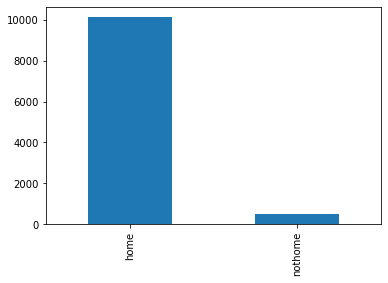

In [227]:
data.Label.value_counts().plot(kind='bar')

In [228]:
# the full dataset contains features for SMTP, NDP, ICMP, etc.
# here we'll grab just the relevant features for HTTP. 
# relevant_features = [
#   fill features to filter to, if desired. Else leave commented out and all features will be used.
# ]
#Subset the data with only the relevant features, leave as is if desire no feature engineering (will take longer)
#data = data[relevant_features]
#Normalize data, performs better with SVM
data["Flow Duration"] = np.log((data["Flow Duration"] + 0.1).astype(float)) 

if len(data) !=  0:
    data.loc[data['Label'] == "home","nothome"] = 1 
    data.loc[data['Label'] != "home","nothome"] = -1

target = data['nothome']

outliers = target[target == -1]
print("outliers.shape", outliers.shape)
print("outlier fraction", outliers.shape[0]/target.shape[0])
print(target)

data.drop(["Label", "nothome"], axis=1, inplace=True)
data.drop(['Flow ID','Dst IP','Src IP','Timestamp'], axis=1, inplace=True)
##Verify that the dimension has dropped by 1 and therefore label has been removed
data.shape

outliers.shape (500,)
outlier fraction 0.0471253534401508
0      1.0
4      1.0
5      1.0
6      1.0
8      1.0
      ... 
830   -1.0
832   -1.0
834   -1.0
836   -1.0
838   -1.0
Name: nothome, Length: 10610, dtype: float64


(10610, 79)

In [230]:
targethomedata["Flow Duration"] = np.log((targethomedata["Flow Duration"] + 0.1).astype(float)) 

if len(targethomedata) !=  0:
    targethomedata.loc[targethomedata['Label'] == "home","nothome"] = 1 
    targethomedata.loc[targethomedata['Label'] != "home","nothome"] = -1

targethome = targethomedata['nothome']
print(targethome)

targethomedata.drop(["Label", "nothome"], axis=1, inplace=True)
targethomedata.drop(['Flow ID','Dst IP','Src IP','Timestamp'], axis=1, inplace=True)
##Verify that the dimension has dropped by 1 and therefore label has been removed
targethomedata.shape

C:\Users\b-byr\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
118501    1.0
118504    1.0
118505    1.0
118506    1.0
118511    1.0
Name: nothome, Length: 38608, dtype: float64


(38608, 79)

In [231]:
#Split some training and test data from the source set to evaluate later
from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(data, target, train_size = 0.8)

In [232]:
from sklearn import svm
nu = outliers.shape[0] / target.shape[0]
print("nu", nu)
#Set model with hypermarameters, rbf is the most common kernel (non linear) and gamma can be modified later to fine tune the success
model = svm.OneClassSVM(nu=0.05, kernel='rbf', gamma=2e-20) 
model.fit(train_data)

nu 0.0471253534401508


OneClassSVM(gamma=2e-20, nu=0.05)

In [233]:
##Test the model
from sklearn import metrics

preds = model.predict(train_data)
targs = train_target 

print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds)) 
print("recall: ", metrics.recall_score(targs, preds))
print("f1: ", metrics.f1_score(targs, preds))
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))

accuracy:  0.9065739868049011
precision:  0.9495486583405466
recall:  0.9522569444444444
f1:  0.9509008730109592
area under curve (auc):  0.4949963967505241


In [234]:
##Evaluate on unseen test data
preds = model.predict(test_data)
targs = test_target 
print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds)) 
print("recall: ", metrics.recall_score(targs, preds))
print("f1: ", metrics.f1_score(targs, preds))
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))

accuracy:  0.9147031102733271
precision:  0.9636996519144704
recall:  0.9472140762463344
f1:  0.9553857530194725
area under curve (auc):  0.49334388022843034


In [254]:
##Evaluate target home device

from sklearn.model_selection import train_test_split
targethomedata.fillna(targethomedata.mean(), inplace=True)
newhome_data, newtest_data, newhome_target, newtest_target = train_test_split(targethomedata, targethome, train_size = 0.8)

In [245]:
print(newhome_data)
print(newhome_target)

        Src Port  Dst Port  Protocol  Flow Duration  Tot Fwd Pkts  \
65932         80     35302         6       7.597446             1   
117111     55970       443         6      18.466848             3   
25924      46800      5228         6      18.317331             4   
104805     56692       443         6      18.466518             3   
43842      46800      5228         6      18.316765             4   
...          ...       ...       ...            ...           ...   
97852      51559      5228         6      18.316737             4   
61406         80     51582         6       8.508778             1   
71700      45869       443         6       7.949480             2   
109257     57765        80         6       9.364957             5   
72144      45028       443         6       7.951595             2   

        Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
65932              1              0.0              0.0              0.0   
117111             5 

In [255]:
preds=model.predict(newhome_data)
targs=newhome_target
print("accuracy: ", metrics.accuracy_score(targs, preds))
print("precision: ", metrics.precision_score(targs, preds)) 
print("recall: ", metrics.recall_score(targs, preds))
print("f1: ", metrics.f1_score(targs, preds))
print("area under curve (auc): ", metrics.roc_auc_score(targs, preds))

accuracy:  0.27559412031341063
precision:  1.0
recall:  0.27559412031341063
f1:  0.43210315244428654


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [248]:
##To save model for later use
outputfile = 'oneclass_v1.model'
import joblib
joblib.dump(model, outputfile, compress=9)

['oneclass_v1.model']